In [30]:
from __future__ import division

import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
%matplotlib inline  

# To Do today!
- better understand the lam for the poisson dist function
- gaussian that dictates the arrivals for the poission - can change std
- above invovles making the poisson a matrix input - check out as a raster
- distance matrix... again use guassian

- the conducntances and gains should be combined? 

### Network set up - 
- check rise and decay times
- distance matrix use guassian?
- inhibitory cell is firing after the rest... :/ shouldnt be this way around. 
- maybe sum the poission inputs and take them down to the pv cell

(51, 51)


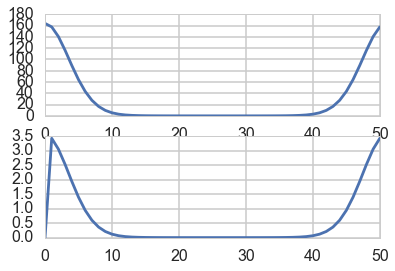

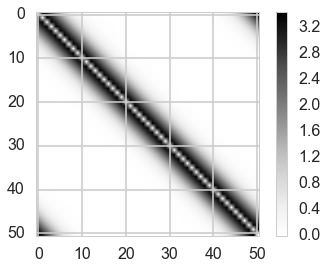

In [114]:
# First basic set up:
np.random.seed(8)
n_neurons  = 51#51  # number of neurons
dt         = .01 # integration step [ms]
sim_length = 1000 # total time of simulaiton [ms]

n_timepoints  = int(sim_length//dt) 
V_mat  = np.zeros((n_neurons,n_timepoints))    # hold membrane traces
V_mat[:,0]  = -70+2*np.random.randn(n_neurons) # should really be set from class params
V_mat[-1,0] = -60+0*np.random.randn(1)         # last neuron is the inhibitory one

U_mat  = np.zeros((n_neurons,n_timepoints))     # hold the recurrent U values (in izhikevich) #was 40
U_mat[:,0]  = 50+5*np.random.randn(n_neurons) # was 40
U_mat[-1,:] = 0
G1_mat  = np.zeros((n_neurons,n_timepoints))   # G holds the "standard" conductances elicited on connected 
G2_mat  = np.zeros((n_neurons,n_timepoints))   # neurons by this neuron. Last row is for inhib. 
#G_mat = np.zeros((n_neurons,n_timepoints))

G1NL_mat  = np.zeros((n_neurons,n_timepoints)) # G NL holds the conductances dependent on coaactivation of
G2NL_mat  = np.zeros((n_neurons,n_timepoints)) # neighbouring synpases
#GNL_mat = np.zeros((n_neurons,n_timepoints))

time   = np.arange(0,n_timepoints*dt,dt)

# Make distance matrix D?
# change this to gaussian so can set the sigma of distance matrix more easily - wald? read how to use
# dists in sicpy stats package
D = np.exp(n_neurons/10*np.cos(2*np.pi*np.array(range(n_neurons))/n_neurons))# ORIGINALLY /5

plt.subplot(211);plt.plot(D)
D[0] = 0 # why set to 0? - so each neuron is not non-linear with itself? - Maybe it could stay not null...
D    = (D/np.sum(D))*15*100/n_neurons
plt.subplot(212);plt.plot(D)
D    = la.toeplitz(D)
print(D.shape)
plt.figure();plt.imshow(D); plt.colorbar()



(51, 51)


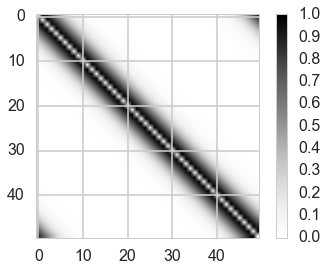

In [150]:
print(D.shape)
dmat = D[:-1, :-1]/np.max(D)
plt.figure();plt.imshow(dmat); plt.colorbar()
plt.savefig('d_marix.svg')

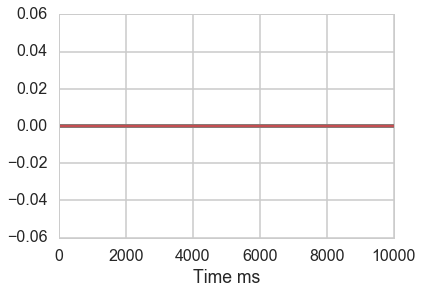

In [115]:
# current injection + noise (allowed to just be current :p) (in pA)
i1,i2 = int(200/dt),int(600/dt) # current injection timepoints
noise_input = 0*np.random.randn(n_neurons,n_timepoints) 
iclamp      = np.zeros((n_neurons, n_timepoints))
iclamp[:,i1:i2]  = 0
iclamp[-1,i1:i2] = 0
i_ext_mat    = iclamp + noise_input 

plt.plot(time, i_ext_mat.T);plt.xlabel('Time ms')

The Poisson distribution

$$f(k; \lambda)=\frac{\lambda^k e^{-\lambda}}{k!}$$

lambda : Expectation of interval, should be >= 0


In [116]:
# check out scipy.stats etc... might be a more convienant
def guassian(x, mu, sig):
    return np.exp(-np.power(x-mu,2.0)/ (2.0*np.power(sig,2.0)))

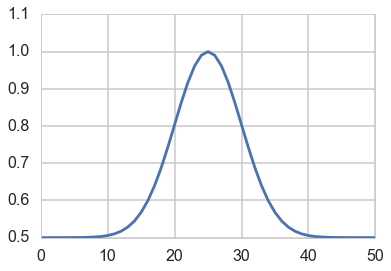

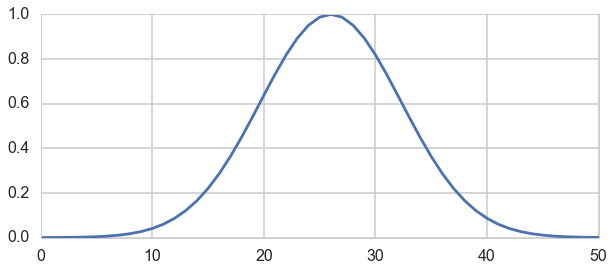

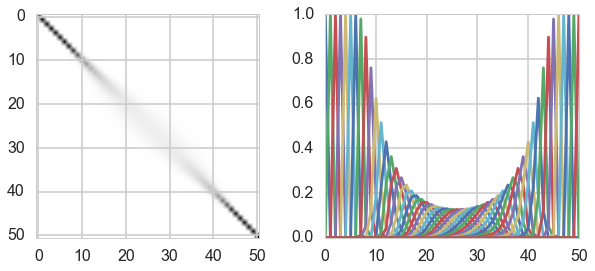

In [117]:
n_positions = np.array(range(n_neurons)) 
offset = 0                                 # eventually be used for changeing the bump location
mu = int(n_positions.shape[0]/2) + offset
sigma = 5#50 # or twenty
lambda_vector = .5*guassian(n_positions, mu,sigma) + .5
lambda_vector[lambda_vector<0.001]=0.001
plt.plot(lambda_vector)

Dc        = np.zeros((n_neurons,n_neurons))
aux_scale = np.arange(-n_neurons//2,n_neurons//2) 
bump = np.exp(-.0125*aux_scale**2);
for k in range(n_neurons):
    v = np.exp(-.05/bump[k]*aux_scale**2)
    v = v/sum(v)
    Dc[k,:] = np.roll(v,aux_scale[k])
    
plt.figure(figsize=(10,4))
plt.plot(bump)    
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Dc)
plt.subplot(1,2,2)
plt.plot(Dc);



In [118]:
s_ext_mat = np.zeros((n_neurons,n_timepoints))

base_rate = dt # this is a real hack at the moment, marco had dt*nspikes or something. 
# get a better undestanding of the poission dist!

#plt.figure(figsize=(8,5))
np.random.seed(8)
for i,input_strength  in enumerate(lambda_vector):
    s_ext_row = np.random.poisson(input_strength*base_rate, n_timepoints) 
    s_ext_mat[i,:] = s_ext_row
    #plt.subplot(lambda_vector.shape[0],1,i+1)
    #plt.plot(s_ext_row)
    #plt.ylim(0,2)
    #plt.axis('off')

#s_ext_mat[-1,:] = np.sum(s_ext_mat, axis = 0)>=2 # switch to where more than two
#s_ext_mat[-1,:] = np.sum(s_ext_mat, axis = 0)*0 # switch to where more than two
print(s_ext_mat.shape)
print(np.sum(s_ext_mat, axis = 1).astype(int))

(51, 999999)
[ 5039  5075  5111  4987  5042  5011  4995  5028  5038  5046  5046  5165
  5232  5290  5500  5762  6000  6543  6931  7492  8134  8545  8988  9755
  9872 10039  9791  9660  9064  8611  7973  7547  6915  6419  5997  5802
  5365  5310  5172  5048  4957  5183  5101  5053  4953  5028  4928  5023
  5010  5016  4926]


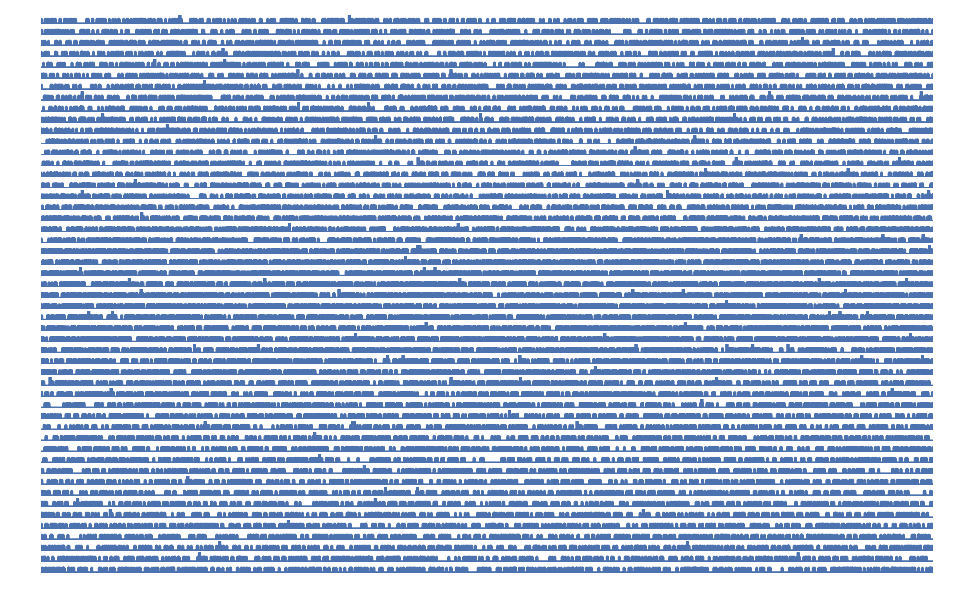

In [64]:
plt.figure(figsize=(16,10))
for i in range(lambda_vector.shape[0]):
    plt.subplot(lambda_vector.shape[0],1,i+1)
    plt.plot(s_ext_mat[i,:])
    plt.ylim(0,2)
    plt.axis('off')

In [119]:
# convolve the spikes with the synaptic kernels:

g_ext_mat = np.zeros((n_neurons,n_timepoints))

# pyramidal external input
tau1 = 3
tau2 = .7
g0 = np.exp(-time/tau1) - np.exp(-time/tau2)
g0 = g0/np.sum(g0)/dt # don't get this step...

# pv external input
tau1_pv = 1.1
tau2_pv = .35
g1 = np.exp(-time/tau1_pv) - np.exp(-time/tau2_pv)
g1 = g1/np.sum(g1)/dt

for i in range(s_ext_mat.shape[0]-1):
    #print(i, end = ', ')
    #pyg_ext_row = np.convolve(s_ext_mat[i,:],g0,mode='full')[0:n_timepoints]
    pyg_ext_row = np.real(np.fft.ifft(np.fft.fft(s_ext_mat[i,:])*np.fft.fft(g0))) # FFT convolution: here you go.
    g_ext_mat[i,:] = pyg_ext_row

pvg_ext_row = np.real(np.fft.ifft(np.fft.fft(s_ext_mat[-1,:])*np.fft.fft(g1))) # scaling as soooo many! (what to do here?)
g_ext_mat[-1,:] = pvg_ext_row

g_ext_mat_c = Dc.dot(g_ext_mat)

## Induce correlations in the midle neurons with Dc mixing matrix
g_ext_mat_c = Dc.dot(g_ext_mat)

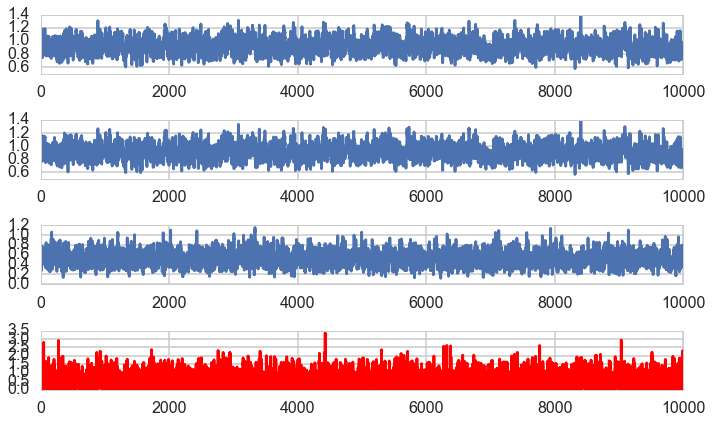

In [120]:
plt.figure(figsize=(10,6))
plt.subplot(4,1,1);plt.plot(time, g_ext_mat_c[n_neurons//2,:])
plt.subplot(4,1,2);plt.plot(time, g_ext_mat_c[n_neurons//2 +1,:])
plt.subplot(4,1,3);plt.plot(time, g_ext_mat_c[n_neurons//4,:])
plt.subplot(4,1,4);plt.plot(time, g_ext_mat_c[-1,:], 'r')
#plt.xlim(0,10000)
plt.tight_layout()

In [121]:
# PV cell
class PV:
    'To store parameters for PV cell as class variables' 
    cm     = 90    # total membrane capaciatance
    v_r    = -60.6
    v_t    = -43.1
    v_peak = 2.5
    a      = 0.1
    b      = -0.1
    c      = -70#67
    d      = 0.1
    k_low  = 1.7
    k_high = 14
    
    # syanptic parameters
    tau1_gaba  = 6.5#10
    tau2_gaba   = 0.6#1
    
    e_glu   = 0 
    e_gaba  = -70 # currently not used as no inhibitory syanpse on pv

class Py:
    'To store parameters for PV cell as class variables' 
    cm     = 100 
    v_r    = -70.8 # their intial is 61.8
    v_t    = -57.0
    v_peak = 22.6
    a      = 0.001#2
    b      = 3
    c      = -62.8
    d      = 10
    k_low  = 0.5
    k_high = 3.3
    i_shift = 0
    
    # syanptic parameters
    tau1_ampa   = 3 # 1st 10
    tau2_ampa   = 0.7 # # list 1 # tau 2 is the rise
    
    # calling nmda even though not!
    tau1_NMDA   = 80
    tau2_NMDA   = 2
    
    
    e_glu   = 0 
    e_gaba  = -70 
   

In [140]:
# run simulation
# future - global and individaul gains
Ext_gain  = 2
EIL_gain  = 6 #2.5 # E to I linear gain
EINL_gain = 0      # E to I non-linear gain
IEL_gain  = 1        # I to E linear gain (multiplies IV (bad name) individualinhibitory gains)

#gains
IV = 40*np.ones((n_neurons))              # inhibitory gains from pv conductance onto other cells
IV[-1] = 30*5 /IEL_gain                   # set to specifiy the auto inhibition - de mess this!
LV = 2*100/n_neurons*np.ones((n_neurons)) # gains for the excitatory onto the inhib
LV[-1] = 0                                # set to zero to stop inhib exciting on itself

traces = np.zeros((3, n_timepoints))
for i in range(n_timepoints-1): 
    V       = V_mat[:,i] 
    u       = U_mat[:,i]
    i_ext   = i_ext_mat[:,i]
    g_ext   = Ext_gain*g_ext_mat_c[:,i]

    G1      = G1_mat[:,i] 
    G2      = G2_mat[:,i]
    G       = EIL_gain*(G1-G2) # change with global gains
    G[-1]   = IEL_gain/EIL_gain*G[-1] # need to apply the IE gain and remove the EI gain added line above
    G1NL    = G1NL_mat[:,i]
    G2NL    = G2NL_mat[:,i]
    GNL     = EINL_gain*(G1NL-G2NL)
    
    # check wich k  to use 
    k_vec = Py.k_high + (Py.k_low - Py.k_high)*(V <=Py.v_t)
    k_vec[-1] = PV.k_high + (PV.k_low - PV.k_high)*(V[-1]<=PV.v_t)
    
    # Euler integration scheme
    # Excitatory neurons
    i_syn = (IV*G[-1]*(Py.e_gaba - V) # combine external glu and gaba here
            + g_ext*(Py.e_glu  - V)   # excitatory external
            )                         # is IV linear gains?
    i_app = i_ext + i_syn
    dV   = ((k_vec*(V-Py.v_r)*(V-Py.v_t) - u + i_app)/Py.cm)*dt
    du   = Py.a*(Py.b*(V-Py.v_r) - u)*dt
    
    # adjust values if neuron fired
    dV[V>Py.v_peak] = -V[V>Py.v_peak] + Py.c
    du[V>Py.v_peak] = du[V>Py.v_peak] + Py.d
    
    # Inhibitory neuron - basically overwrite the last row of the column vector 
    # need to store actual stuff
    nl_g       = np.sqrt(GNL.T.dot(D.dot(GNL)))*(PV.e_glu - V[-1])
    l_g        = LV.T.dot(G) *(PV.e_glu - V[-1])      
    pv_gaba_g  = IV[-1]*G[-1]*(-1) *(PV.e_gaba - V[-1])
    
    i_syn_pv   = (IV[-1]*G[-1]*(PV.e_gaba - V[-1]) # inhibitory auto connection... 
                 +(np.sqrt(GNL.T.dot(D.dot(GNL)))  # non-linear - only large when coactivation of nearby synapses
                                                   # D.dot(G) used to be D.dot(GNL) - Back to D.dot(GNL) baby!
                 + LV.T.dot(G)                     # linear 
                 + .0*g_ext[-1])*(PV.e_glu - V[-1]))  # external... then ∑g's and * driving force. 
               
    i_app_pv = i_ext[-1] + i_syn_pv
    dV[-1] = ((k_vec[-1]*(V[-1]-PV.v_r)*(V[-1]-PV.v_t) - u[-1] + i_app_pv)/PV.cm)*dt
    du[-1] = PV.a*(PV.b*(V[-1]-PV.v_r) - u[-1])*dt
    
    # adjust values if neuron fired
    if V[-1]>PV.v_peak:
        dV[-1] = -V[-1] + PV.c
        du[-1] = du[-1] + PV.d
    
    # Py synapses
    # excitatory linear
    dG1 = 1/Py.tau1_ampa*(-G1)*dt + (V>=Py.v_peak)     # bi-exponential decay, add 1 if spike.
    dG2 = 1/Py.tau2_ampa*(-G2)*dt + (V>=Py.v_peak) 
    
    # excitatory non-linear
    dG1NL = 1/Py.tau1_NMDA*(-G1NL)*dt + (V>=Py.v_peak) # bi-exponential decay 
    dG2NL = 1/Py.tau2_NMDA*(-G2NL)*dt + (V>=Py.v_peak)
    
    # PV synapses
    # inhibitory gaba
    dG1[-1] = 1/PV.tau1_gaba*(-G1[-1])*dt + (V[-1]>=PV.v_peak)
    dG2[-1] = 1/PV.tau2_gaba*(-G2[-1])*dt + (V[-1]>=PV.v_peak)
    
    dV[dV>50] = 50;      # stop voltage changing too quickly (for improved numerical stability when neurons spike)
    
    V_mat[:,i+1]  = V + dV     # update everything
    U_mat[:,i+1]  = u + du
    G1_mat[:,i+1] = G1 + dG1
    G2_mat[:,i+1] = G2 + dG2
    G1NL_mat[:,i+1] = G1NL + dG1NL
    G2NL_mat[:,i+1] = G2NL + dG2NL
    
    traces[0,i+1] = nl_g
    traces[1,i+1] = l_g
    traces[2,i+1] = pv_gaba_g
    
G_mat   = G1_mat - G2_mat
GNL_mat = G1NL_mat - G2NL_mat

In [141]:
v_mat_L1_5_NL_0_5 is V_mat

False

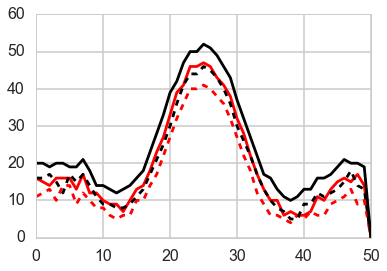

In [142]:
#v_mat_L1_NL_1 = V_mat.copy()
#v_mat_L3_NL_0 = V_mat.copy()
v_mat_L6_NL_0 = V_mat.copy()
#v_mat_L1_5_NL_0_5 = V_mat.copy()
#v_mat_L2_5_NL_0 = V_mat.copy()
plt.plot(np.sum(v_mat_L1_NL_1[:,:]>=Py.v_peak,axis = 1), 'r--')
plt.plot(np.sum(v_mat_L1_5_NL_0_5[:,:]>=Py.v_peak,axis = 1), 'r')
plt.plot(np.sum(v_mat_L6_NL_0[:,:]>=Py.v_peak,axis = 1), 'k--')
plt.plot(np.sum(v_mat_L2_5_NL_0[:,:]>=Py.v_peak,axis = 1), 'k')

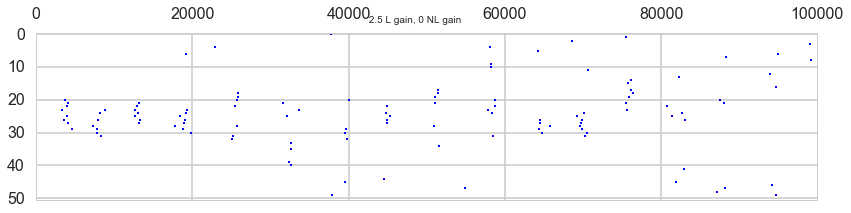

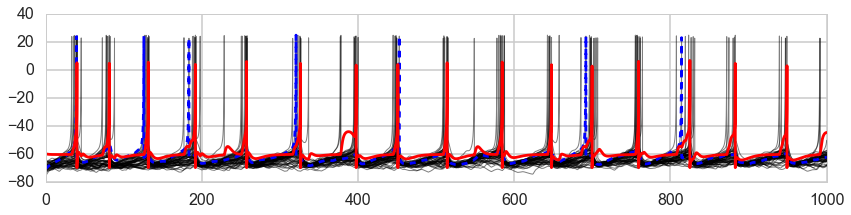

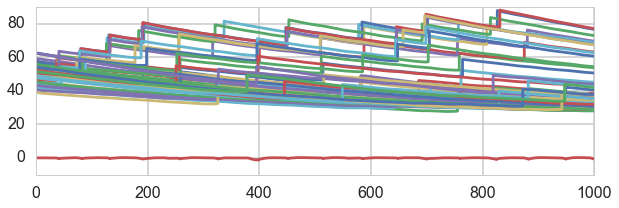

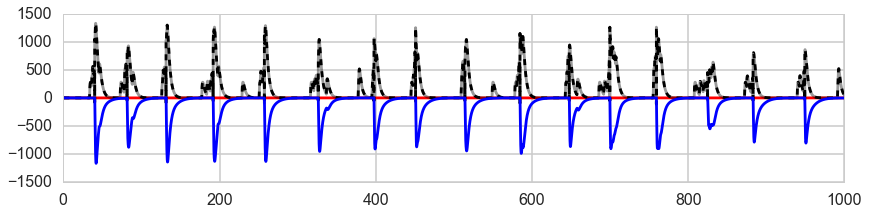

In [105]:
plt.figure(figsize=(14,3))
plt.suptitle(' 2.5 L gain, 0 NL gain')
plt.spy(V_mat>=Py.v_peak,aspect='auto',markersize=2);
plt.figure(figsize=(14,3))
plt.plot(time, V_mat[:-1,:].T, 'k', linewidth = 1, alpha = 0.5);
#plt.plot(time, V_mat[-1,:].T, 'r');
plt.plot(time, V_mat[n_neurons//2,:].T, 'b--');
plt.plot(time, V_mat[-1,:].T, 'r');

plt.figure(figsize=(10,3))
plt.plot(time,U_mat.T);

#plt.figure(figsize=(14,3))
#¢plt.plot(time,G_mat[:-1,:].T*5,'k')   # this is the excitatory synapses onto the pv cell
#plt.plot(time,GNL_mat[:-1,:].T,'r')   # this is the NL excitatory synapses onto the pv cell
#plt.plot(time,-G_mat[-1,:].T,'b')     # inhib conductance onto pyramdial cells

plt.figure(figsize=(14,3))
plt.plot(time,traces[0], 'r', label = 'nmda')
plt.plot(time,traces[1], 'k', label = 'ampa', alpha = 0.4)
plt.plot(time,traces[1]+traces[0], 'k--', label = 'ampa+nmda', alpha = 1)
plt.plot(time,-traces[2], 'b', label = 'gaba',)
#plt.ylim(-800,1000)

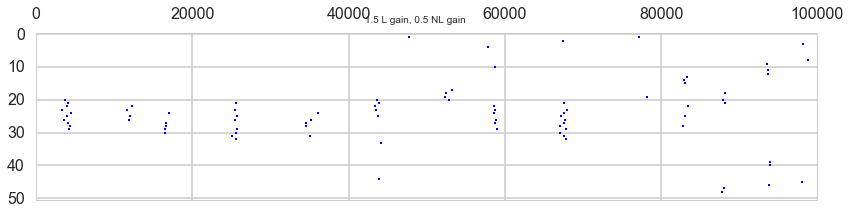

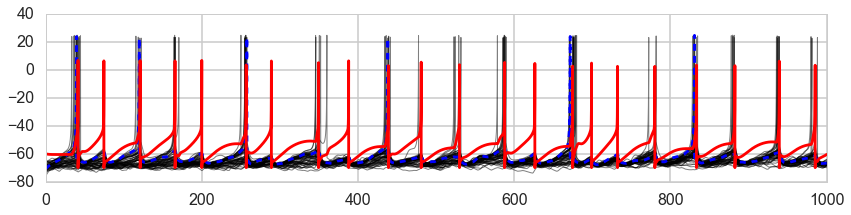

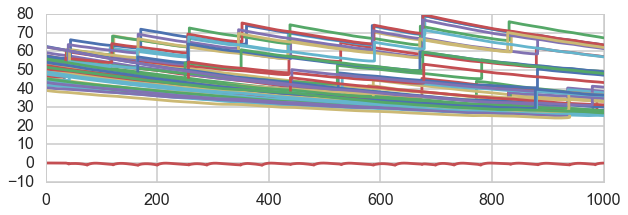

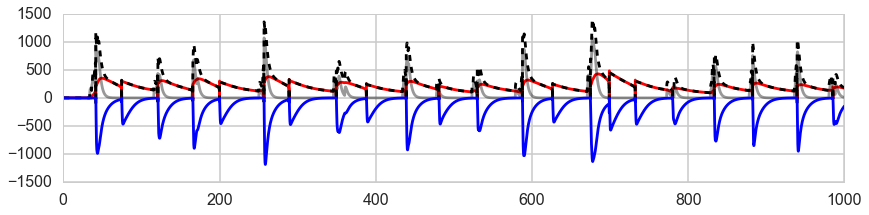

In [91]:
plt.figure(figsize=(14,3))
plt.suptitle(' 1.5 L gain, 0.5 NL gain')
plt.spy(V_mat>=Py.v_peak,aspect='auto',markersize=2);
plt.figure(figsize=(14,3))
plt.plot(time, V_mat[:-1,:].T, 'k', linewidth = 1, alpha = 0.5);
#plt.plot(time, V_mat[-1,:].T, 'r');
plt.plot(time, V_mat[n_neurons//2,:].T, 'b--');
plt.plot(time, V_mat[-1,:].T, 'r');

plt.figure(figsize=(10,3))
plt.plot(time,U_mat.T);

#plt.figure(figsize=(14,3))
#plt.plot(time,G_mat[:-1,:].T*5,'k')   # this is the excitatory synapses onto the pv cell
#plt.plot(time,GNL_mat[:-1,:].T,'r')   # this is the NL excitatory synapses onto the pv cell
#plt.plot(time,-G_mat[-1,:].T,'b')     # inhib conductance onto pyramdial cells

plt.figure(figsize=(14,3))
plt.plot(time,traces[0], 'r', label = 'nmda')
plt.plot(time,traces[1], 'k', label = 'ampa', alpha = 0.4)
plt.plot(time,traces[1]+traces[0], 'k--', label = 'ampa+nmda', alpha = 1)
plt.plot(time,-traces[2], 'b', label = 'gaba',)
#plt.ylim(-800,1000)

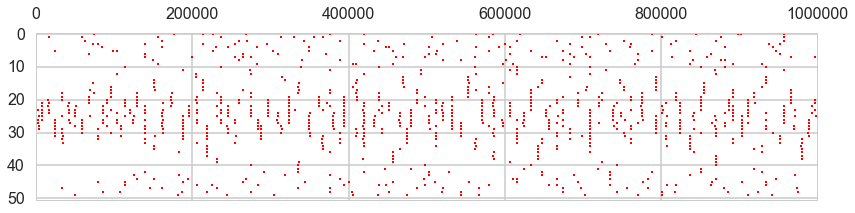

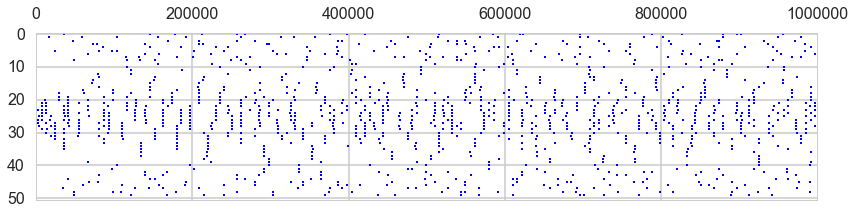

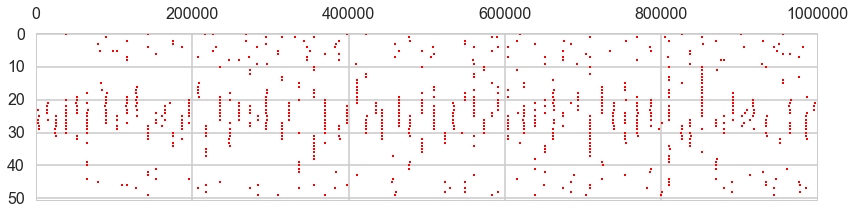

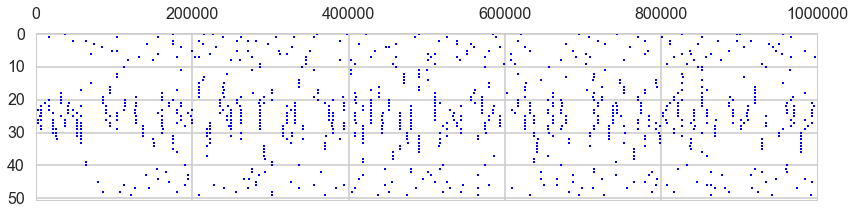

In [143]:
plt.figure(figsize=(14,3))
#plt.suptitle(' 2.5 L gain, 0 NL gain')
plt.spy(v_mat_L1_5_NL_0_5>=Py.v_peak,aspect='auto',markersize=2, color = 'r');



plt.figure(figsize=(14,3))
plt.spy(v_mat_L2_5_NL_0>=Py.v_peak,aspect='auto',markersize=2);


plt.figure(figsize=(14,3))
plt.spy(v_mat_L1_NL_1>=Py.v_peak,aspect='auto',markersize=2,color= 'r');

plt.figure(figsize=(14,3))
plt.spy(v_mat_L6_NL_0>=Py.v_peak,aspect='auto',markersize=2);

In [ ]:
plt.plot(np.sum(v_mat_L1_5_NL_0_5[:,:]>=Py.v_peak,axis = 1), 'r')
plt.plot(np.sum(v_mat_L6_NL_0[:,:]>=Py.v_peak,axis = 1), 'k--')

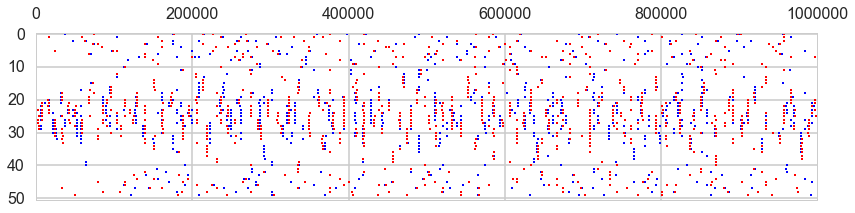

In [144]:
plt.figure(figsize=(14,3))
plt.spy(v_mat_L6_NL_0>=Py.v_peak,aspect='auto',markersize=2);
plt.spy(v_mat_L1_5_NL_0_5>=Py.v_peak,aspect='auto',markersize=2, color = 'r');